In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from collections import defaultdict


In [2]:
#data load 
df = pd.read_csv('Train.csv', encoding = 'cp949')
df.head()
validation = pd.read_csv('Validation.csv', encoding = 'cp949')
test = pd.read_csv('Test.csv', encoding = 'cp949')

## 변수 설명
1. Movie : 영화 제목

2. Playdate : 개봉 날짜
   Play_month : 개봉 월
   Weekdays : 개봉 요일

3. Rep_Nationality : 대표 국가

4. Grade : 관람 등급

5. Rep_production : 대표 제작사
   Prod_grade : 제작사 등급
   Prod_avg_grade : 제작사 평균 등급
                    (제작사는 시나리오 선정, 투자자 물색, 배우 캐스팅 등의 역할을 맡는다.
                     따라서 배우 등급, 배급사 등급, 감독 등급, 영화 평점 등을 반영하여 계산하였다.)

6. Rep_distribution : 대표 배급사
   Dist_grade : 배급사 등급
                (우리나라의 경우 배급사가 메인 투자자인 경우가 많으며, 배급사가 스크린을 얼마나 확보하느냐에 따라 영화의 성과가 결정된다.
                 따라서 배급사에 따른 개봉 첫째주의 스크린 수를 파악하여 이를 배급사의 등급으로 대체하였다.)

7. Rep_genre : 대표 장르

8. Rep_director : 대표 감독
   Direc_avg_grade : 감독 평균 등급
                     (감독 등급은 2년간 감독한 영화의 평균 평점으로 대체하였다.

9. Rep_actor1 : 대표 배우1
   Actor1_grade : 대표 배우1 등급
   Rep_actor2 : 대표 배우2
   Actor2_grade : 대표 배우2 등급
   Rep_actor3 : 대표 배우3
   Actor3_grade : 대표 배우3 등급
   Rep_actor4 : 대표 배우4
   Actor4_grade : 대표 배우4 등급
   Rep_actor5 : 대표 배우5
   Actor5_grade : 대표 배우5 등급
                  (배우의 등급은 2년간 배우가 출연한 영화들의 2주차 평균 누적관객수를 변환한 값이다.)

10. Critic_star : 평론가 평점

11. Netizen_star_before_play : 개봉 전 네티즌 평점
    Num_of_participants_before_play : 개봉 전 평가 참여 인원

12. Netizen_star_after_play : 개봉 후 네티즌 평점

13. Diff_netizen_star : 개봉 전/후 평점 차이

14. Expect_index_wannasee : 개봉 전 기대지수(보고싶어요)
    Expect_index_notreally : 개봉 전 기대지수(글쎄요)
    Ratio_notreally : 글쎼요 비율

15. Week1_isplay : 1주차 상영 여부
    Week1_playdays : 1주차 상영일수
    Week1_holiday : 1주차 공휴일수(주말 포함)
    Week1_sales : 1주차 매출액
    Week1_sales_share : 1주차 매출액 점유율
    Week1_audience : 1주차 관객수
    Week1_screen : 1주차 스크린수
    Week1_Screening : 1주차 상영횟수

## 과제 

킹스맨2  0927 개봉
남한산성 0930 개봉
넛잡 1003 개봉


**데이터를 기준으로 킹스맨2, 남한산성 => 1주차 데이터 안 스고 2주차 누적 관객 맞추기, 넛잡 => 1주차 데이터 안쓰고 1주차 누적관객수 맞추기 **

각각에 대한 모델링을 따로 할필요가 있다. 



In [3]:
#결측치 처리 
total = pd.concat([df, validation, test])
total.isnull().sum()
#Rep_production 791, Rep_actor1 115, Rep actor2 163, Rep_actor3 347, Rep_actor4 544, Rep_actor5 683
#Critic_star 232, Naver_star_before_play 31, Naver_participants_before_play 31
#Naver_expect_index_wannasee 53, Naver_expect_notreally 53
'''
결측치를 살펴보면 대표 제작사, 대표 배우, 평론가 평점 및 네이에서 크롤링해온 평정들로 
구성되어 있다. 
대표 제작사의 경우 관련 데이터가 없으며 결측치가 과반수 이상으로 많기 때문에 이를 삭제한다. 
대표 배우의 경우 관련 데이터는 없지만 결측치가 많지 않기 때문에 관련 파생 변수로 
배우 점수를 구성할때 0으로 대체하도록 한다. 
평점의 경우 네이버에서 검색했을때 나오지 않는 영화들로 관련 데이터가 없으므로 0으로 대체한다.
-> Rep_production 삭제 
-> Rep_actor : score 변수를 만들때 0으로 점수를 대체한다. 
-> 평점 관련 : 0으로 대체
'''


'\n결측치를 살펴보면 대표 제작사, 대표 배우, 평론가 평점 및 네이에서 크롤링해온 평정들로 \n구성되어 있다. \n대표 제작사의 경우 관련 데이터가 없으며 결측치가 과반수 이상으로 많기 때문에 이를 삭제한다. \n대표 배우의 경우 관련 데이터는 없지만 결측치가 많지 않기 때문에 관련 파생 변수로 \n배우 점수를 구성할때 0으로 대체하도록 한다. \n평점의 경우 네이버에서 검색했을때 나오지 않는 영화들로 관련 데이터가 없으므로 0으로 대체한다.\n-> Rep_production 삭제 \n-> Rep_actor : score 변수를 만들때 0으로 점수를 대체한다. \n-> 평점 관련 : 0으로 대체\n'

In [4]:
#평점 관련 데이터 0으로 대체 
star_list = ['Critic_star','Naver_star_before_play','Naver_participants_before_play','Naver_expect_index_wannasee',
            'Naver_expect_index_notreally']
total[star_list] = total[star_list].fillna(0)
total.isnull().sum()

Movie                               0
Playdate                            0
Playtime                            0
Play_month                          0
Weekdays                            0
Rep_Nationality                     0
Grade                               0
Rep_production                    791
Rep_distributor                     0
Rep_genre                           0
Rep_director                        0
Rep_actor1                        115
Rep_actor2                        163
Rep_actor3                        347
Rep_actor4                        544
Rep_actor5                        683
Critic_star                         0
Naver_star_before_play              0
Naver_participants_before_play      0
Naver_expect_index_wannasee         0
Naver_expect_index_notreally        0
Watcha_star                         0
Watcha_participants                 0
Watcha_expect_index_wannasee        0
Watcha_comments                     0
Week1_playdays                      0
Week1_holida

In [5]:
#Rep_production 삭제 
total = total.drop('Rep_production', axis = 1)
total.isnull().sum()

Movie                               0
Playdate                            0
Playtime                            0
Play_month                          0
Weekdays                            0
Rep_Nationality                     0
Grade                               0
Rep_distributor                     0
Rep_genre                           0
Rep_director                        0
Rep_actor1                        115
Rep_actor2                        163
Rep_actor3                        347
Rep_actor4                        544
Rep_actor5                        683
Critic_star                         0
Naver_star_before_play              0
Naver_participants_before_play      0
Naver_expect_index_wannasee         0
Naver_expect_index_notreally        0
Watcha_star                         0
Watcha_participants                 0
Watcha_expect_index_wannasee        0
Watcha_comments                     0
Week1_playdays                      0
Week1_holiday                       0
Week1_sales 

In [6]:
#파생 변수 생성 

#감독점수, 배우점수, 배급사 점수 생성 

##감독 점수 생성 - 감독의 평균 영화등급으로 - 사용데이터 : Watcha_star, Naver_star_before_play, Critic_star
director_list = total.Rep_director.tolist()
director_list = set(director_list)
director_score = defaultdict(list)
temp = total[['Rep_director','Naver_star_before_play', 'Watcha_star','Critic_star']]
#print(temp)
#print(temp[temp['Rep_director']=='김한민'].Watcha_star.mean())
for director in director_list:
        director_score['director'].append(director)
        director_score['Watcha_star_mean'].append(temp[temp['Rep_director'] == director].Watcha_star.mean())
        director_score['Naver_star_mean'].append(temp[temp['Rep_director']== director].Naver_star_before_play.mean())
        director_score['Critic_star_mean'].append(temp[temp['Rep_director']==director].Critic_star.mean())
director_score = pd.DataFrame(director_score)
#director_score.to_csv('temp.csv', encoding = 'cp949')

director_score.head()

,Critic_star_mean,Naver_star_mean,Watcha_star_mean,director
0,7.0,9.0,2.9,롭 레터맨
1,6.0,9.0,2.9,닉 리드
2,6.0,9.0,3.2,베다 도캄포 페이주
3,6.0,9.0,2.8,박인제
4,5.0,10.0,2.1,후안 호세 캄파넬라


In [7]:
director_score.Critic_star_mean = director_score.Critic_star_mean/2
director_score.Naver_star_mean = director_score.Naver_star_mean/2
#왓챠에 맞춰주기 위해 2를 나눠줌. 
director_score.head()

,Critic_star_mean,Naver_star_mean,Watcha_star_mean,director
0,3.5,4.5,2.9,롭 레터맨
1,3.0,4.5,2.9,닉 리드
2,3.0,4.5,3.2,베다 도캄포 페이주
3,3.0,4.5,2.8,박인제
4,2.5,5.0,2.1,후안 호세 캄파넬라


In [8]:
director_score['score']=director_score.mean(axis=1)

In [9]:
director_score = director_score[['director','score']]#저장. 

In [10]:
#merge 
director_score.columns = ['Rep_director','director_score']
tot_ds = pd.merge(total, director_score,on='Rep_director')
tot_ds

,Movie,Playdate,Playtime,Play_month,Weekdays,Rep_Nationality,Grade,Rep_distributor,Rep_genre,Rep_director,...,Week2_audience,Week2_screen,Week2_screening,Week3_holiday,Week4_holiday,Week2_Cum_audience,Week3_Cum_audience,Week4_Cum_audience,Week5_Cum_audience,director_score
0,명량,2014-07-30,128,7,수요일,한국,15세이상관람가,씨제이이앤엠(주),액션,김한민,...,4814896,2185,46772,3,2,12122075,15540940,16556133,17034795,3.783333
1,최종병기 활,2011-08-10,122,8,수요일,한국,15세이상관람가,롯데쇼핑㈜롯데엔터테인먼트,액션,김한민,...,1415068,1079,19523,2,2,3489711,4552727,5327290,6440501,3.783333
2,도둑들,2012-07-25,135,7,수요일,한국,15세이상관람가,(주)쇼박스,범죄,최동훈,...,3488656,1737,34679,3,2,7837525,10079961,11481440,12270974,3.866667
3,암살,2015-07-22,139,7,수요일,한국,15세이상관람가,(주)쇼박스,액션,최동훈,...,2960563,1094,32184,2,2,7647796,9491708,11015334,11793736,3.866667
4,베테랑,2015-08-05,124,8,수요일,한국,15세이상관람가,씨제이이앤엠(주),액션,류승완,...,3491532,1115,36383,2,2,7458012,9579065,11176810,12048616,4.083333
5,베를린,2013-01-30,120,1,수요일,한국,15세이상관람가,씨제이이앤엠(주),액션,류승완,...,2345644,1273,26431,2,2,5051182,6099307,6757667,7034090,4.083333
6,국제시장,2014-12-17,126,12,수요일,한국,12세이상관람가,씨제이이앤엠(주),드라마,윤제균,...,3032951,1821,28139,3,2,5312629,8329563,10146564,11405561,3.733333
7,부산행,2016-07-20,118,7,수요일,한국,15세이상관람가,(주)넥스트엔터테인먼트월드(NEW),액션,연상호,...,2596977,1021,34227,2,3,9254256,10369248,11005831,11301325,3.483333
8,서울역,2016-08-17,93,8,수요일,한국,15세이상관람가,(주)넥스트엔터테인먼트월드(NEW),애니메이션,연상호,...,7874,72,721,2,3,143995,144801,144989,145178,3.483333
9,어벤져스: 에이지 오브 울트론,2015-04-23,141,4,목요일,미국/캐나다/호주,12세이상관람가,월트디즈니컴퍼니코리아(주),액션,조스 웨던,...,4147209,1634,58110,2,2,8463197,9592415,10115359,10407923,4.150000


In [11]:
#배급사 점수
#배급사는 배급권을 사들여 작품의 상영권을 극장에 파는 역할을 한다. 따라서 첫주차 스크린수로
#관련 점수를 만들어낼 수 있다. 
distributor_list = set(total.Rep_distributor.tolist())
distributor_score = defaultdict(list)

temp = total[['Rep_distributor','Week1_screen']]

for distributor in distributor_list:
    distributor_score['Rep_distributor'].append(distributor)
    distributor_score['distributor_score'].append(temp[temp['Rep_distributor']==distributor].Week1_screen.mean())

distributor_score = pd.DataFrame(distributor_score)
print(distributor_score.head())


  Rep_distributor  distributor_score
0         퓨어웨이픽쳐스           4.000000
1    (주)제이앤씨미디어그룹         438.666667
2       ㈜영화사 백두대간          13.600000
3     (주)더블앤조이픽쳐스          39.000000
4     주식회사 디에스이이디          28.000000


In [12]:
tot_ds = pd.merge(tot_ds,distributor_score,on='Rep_distributor')

In [13]:
#actor_score 생성 
actor1 = total.Rep_actor1.tolist()
actor2 = total.Rep_actor2.tolist()
actor3 = total.Rep_actor3.tolist()
actor4 = total.Rep_actor4.tolist()
actor5 = total.Rep_actor5.tolist()

actor_list = set(actor1)
print(len(actor_list))
actor_list.update(actor2)
print(len(actor_list))
actor_list.update(actor3)
print(len(actor_list))
actor_list.update(actor4)
print(len(actor_list))
actor_list.update(actor5)
print(len(actor_list))

#전체 2380명의 배우들을 볼수 있다. 
print(actor_list)

760
1379
1812
2138
2380
{nan, '오종혁', '섬머 H. 하웰', '마리 아브게로폴로스', '미셸 모나한', '사라 미셀 겔러', '장춘옥', '브리짓 모나핸', '김훈제', '마츠자카 토리', '임정은', '베키 지', '정경호', '옥타비아 스펜서', '심형탁', '야마구치 캇페이', '나가사쿠 히로미', '김지수', '임윤', '문근영', '이타가키 미즈키', '레이크 벨', '오크스 페글리', '모리카와 아오이', '김환희', '김민규', '다이안 레인', '홍성덕', '송새벽', '스기야마 노리아키', '브렌단 글리슨', '채닝 테이텀', '매튜 그레이 거블러', '패트리시아 아퀘트', '빌 팩스톤', '기욤 갈리엔', '강희선', '박상훈', '카트리나 보우든', '제니퍼 엘', '카일 맥라클란', '신순애', '루이스 C.K.', '앨런 에반젤리스타', '권문정', '지진희', '김조광수', '정연주', '멜리사 맥카시', '고아라', '권소현', '김대현', '이희진', '로시 드 팔마', '왕락단', '캐서린 헤이글', '오레 아티카', '질리언 머레이', '담요문', '구스타브 드 케르베른', '테일러 키니', '김민수', 'CCH 파운더', '샘 록웰', '박정식', '코니시 아야노', '김옥빈', '조우진', '다닐라 코즈로브스키', '알리슨 필', '찰스 댄스', '오수파', '윤계상', '안성기', '유인영', '김응수', '키아라 마스트로얀니', '크리스토프 마리아 허브스트', '한가영', '제이미 도넌', '헬렌 헌트', '데이빗 오예로워', '리암 헴스워스', '제프 골드블럼', '류승범', '산페이 유코', '존 파브로', '다니엘 크레이그', '이청아', '공유', '크리스토퍼 램버트', '김대명', '셰일라 밴드', '마일로 파커', '우디 해럴슨', '하지원', '조쉬 더하멜', '해리슨 포드', '율리크 먼더', '에이미 슈머', '김환진', '조혜인', '히로스에 료코', '마츠야마 켄이치', '매

In [14]:
temp = total[['Rep_actor1','Rep_actor2','Rep_actor3','Rep_actor4','Rep_actor5',
              'Naver_star_before_play', 'Watcha_star','Critic_star']]

In [15]:
#temp 재구성
actor_list = ['Rep_actor'+str(i) for i in range(1, 6)]
print(actor_list)
star_list = ['Naver_star_before_play', 'Watcha_star','Critic_star']
temptemp = pd.DataFrame()

for actor_num in actor_list :
    star_list.append(actor_num)
    star_list
    tmp = temp[star_list]
    tmp.columns= ['Naver_star_before_play', 'Watcha_star','Critic_star','Rep_actor']
    temptemp = pd.concat([temptemp,tmp])
    print(temptemp)
    star_list.pop()
temptemp.drop_duplicates()
print(len(temptemp.Rep_actor))
temptemp.isnull().sum()

['Rep_actor1', 'Rep_actor2', 'Rep_actor3', 'Rep_actor4', 'Rep_actor5']
     Naver_star_before_play  Watcha_star  Critic_star     Rep_actor
0                      9.00          3.6         6.00           최민식
1                      9.00          3.8         7.00           김윤석
2                      9.00          4.0         8.00           황정민
3                      8.00          3.9         7.00           전지현
4                      9.00          3.7         6.00           황정민
5                      8.00          3.6         7.00            공유
6                     10.00          3.8         7.00   로버트 다우니 주니어
7                      9.00          3.5         6.00           황정민
8                     10.00          4.0         7.00           이병헌
9                      9.00          3.9         9.00         샘 워싱턴
10                    10.00          4.2         8.00       매튜 매커너히
11                    10.00          3.6         7.00           송강호
12                    10.00          4.1     

Naver_star_before_play       0
Watcha_star                  0
Critic_star                  0
Rep_actor                 1852
dtype: int64

In [16]:
temptemp.Naver_star_before_play = temptemp.Naver_star_before_play/2
temptemp.Critic_star=temptemp.Critic_star/2

In [17]:
temptemp['actor_score']=temptemp.mean(axis=1)
temptemp.head()
temptemp = temptemp[['Rep_actor','actor_score']]
temptemp = temptemp.groupby(['Rep_actor'],as_index = False).mean()

In [18]:
temptemp.head()

,Rep_actor,actor_score
0,B.D. 웡,3.500000
1,CCH 파운더,4.133333
2,F. 머레이 아브라함,1.333333
3,G-드래곤,3.766667
4,J.K. 시몬스,3.508333


In [19]:
#배우점수 reference
actor_score_dict = temptemp.set_index('Rep_actor').to_dict()
actor_score_dict = actor_score_dict['actor_score']

In [20]:
temp = total[['Movie','Rep_actor1','Rep_actor2','Rep_actor3','Rep_actor4','Rep_actor5']]
temp.Rep_actor1 = temp.Rep_actor1.replace(actor_score_dict)
temp.Rep_actor2 = temp.Rep_actor2.replace(actor_score_dict)
temp.Rep_actor3 = temp.Rep_actor3.replace(actor_score_dict)
temp.Rep_actor4 = temp.Rep_actor4.replace(actor_score_dict)
temp.Rep_actor5 = temp.Rep_actor5.replace(actor_score_dict)

/home/junhee/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [21]:
temp['actor_score']=temp.mean(axis=1)
temp

/home/junhee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Movie,Rep_actor1,Rep_actor2,Rep_actor3,Rep_actor4,Rep_actor5,actor_score
0,명량,3.544444,3.561111,3.544259,3.316667,3.722222,3.537741
1,도둑들,3.453333,3.600000,3.613333,3.911111,3.933333,3.702222
2,베테랑,3.761111,3.867222,3.628571,3.647222,4.166667,3.814159
3,암살,3.911111,3.613333,3.722500,3.647222,3.544259,3.687685
4,국제시장,3.761111,3.450000,3.647222,2.926667,3.333333,3.423667
5,부산행,3.755556,3.383333,3.550000,3.466667,3.260000,3.483111
6,어벤져스: 에이지 오브 울트론,4.157333,3.740000,3.993333,4.083333,3.891667,3.973133
7,검사외전,3.761111,3.673000,3.566333,3.355556,3.433333,3.557867
8,"광해, 왕이 된 남자",3.480952,3.561111,3.309333,3.491667,3.214286,3.411470
9,아바타,3.566667,4.000000,3.966667,4.050000,4.300000,3.976667


In [22]:
temp = temp[['Movie','actor_score']]
tot_ds = pd.merge(tot_ds, temp, on = 'Movie')
print(tot_ds)

                             Movie    Playdate  Playtime  Play_month Weekdays  \
0                               명량  2014-07-30       128           7      수요일   
1                              베테랑  2015-08-05       124           8      수요일   
2                              베를린  2013-01-30       120           1      수요일   
3                             국제시장  2014-12-17       126          12      수요일   
4                      광해, 왕이 된 남자  2012-09-13       131           9      목요일   
5                             히말라야  2015-12-16       125          12      수요일   
6                               공조  2017-01-18       125           1      수요일   
7                              마스터  2016-12-21       143          12      수요일   
8                           인천상륙작전  2016-07-27       110           7      수요일   
9                   미션임파서블:고스트프로토콜  2011-12-15       132          12      목요일   
10                          검은 사제들  2015-11-05       108          11      목요일   
11                          

In [23]:
tot_ds.actor_score = tot_ds.actor_score.replace(np.nan, 0)
print(tot_ds.tail())

          Movie    Playdate  Playtime  Play_month Weekdays Rep_Nationality  \
1119   칠드런 오브 맨  2016-09-22       109           9      목요일       독일/영국/프랑스   
1120  일렉트릭 슬라이드  2015-08-20        90           8      목요일       미국/캐나다/호주   
1121     싱 오버 미  2015-09-24        85           9      목요일       미국/캐나다/호주   
1122    마지막 위안부  2015-08-03        91           8      월요일              한국   
1123         링스  2017-04-06       102           4      목요일       미국/캐나다/호주   

         Grade Rep_distributor Rep_genre Rep_director     ...       \
1119  15세이상관람가       영화사 마농(주)        SF      알폰소 쿠아론     ...        
1120  15세이상관람가    모비딕엔터테인먼트(주)        범죄     트리스탄 패터슨     ...        
1121  12세이상관람가         문화선교연구원     다큐멘터리    제이콥 카인드버그     ...        
1122  15세이상관람가        (주)투윈미디어       드라마           임선     ...        
1123  15세이상관람가       (주)다자인소프트    공포(호러)   하비에르 구티에레즈     ...        

     Week2_screening Week3_holiday Week4_holiday Week2_Cum_audience  \
1119             303             2     

In [24]:
tot_ds.columns
#분석에 사용할 컬럼만을 선택하여 total 이라는 변수에 저장한다. 
total = tot_ds[['Movie','Playtime','Play_month','Weekdays','Rep_Nationality','Grade','Rep_genre',
               'Critic_star','Naver_star_before_play','Naver_participants_before_play',
               'Naver_expect_index_wannasee',
       'Naver_expect_index_notreally', 'Watcha_star', 'Watcha_participants',
       'Watcha_expect_index_wannasee', 'Watcha_comments', 'Week1_playdays',
       'Week1_holiday','Week1_audience', 'director_score', 'distributor_score',
       'actor_score']]

In [25]:
#Week1_audience에 대해 각 변수를 검정한다. 
#각 변수의 타입을 확인하면 다음과 같다. 
total.dtypes
numeric_data = ['Playtime','Play_month','Critic_star','Naver_star_before_play',
               'Naver_participants_before_play', 'Naver_expect_index_wannasee',
               'Naver_expect_index_notreally','Watcha_star','Watcha_participants',
               'Watcha_expect_index_wannasee','Watcha_comments','Week1_playdays',
               'Week1_holiday','director_score','distributor_score','actor_score']
classification_data = ['Weekdays','Rep_Nationality','Grade','Rep_genre']
#Movie는 index, Week1_audience는 목적변수가 됨.

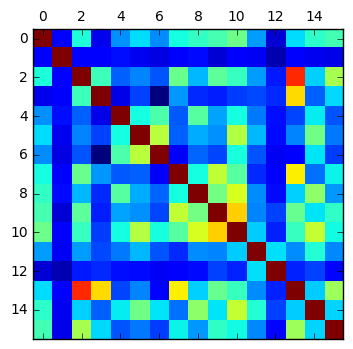

In [26]:
#numerical data에 대해 목적변수와의 상관관계를 보면 다음과 같다. 
#numeric_data.append('Week1_audience')
import matplotlib.pyplot as plt
%matplotlib inline 
numeric_datas=total[numeric_data]
plt.matshow(numeric_datas.corr())

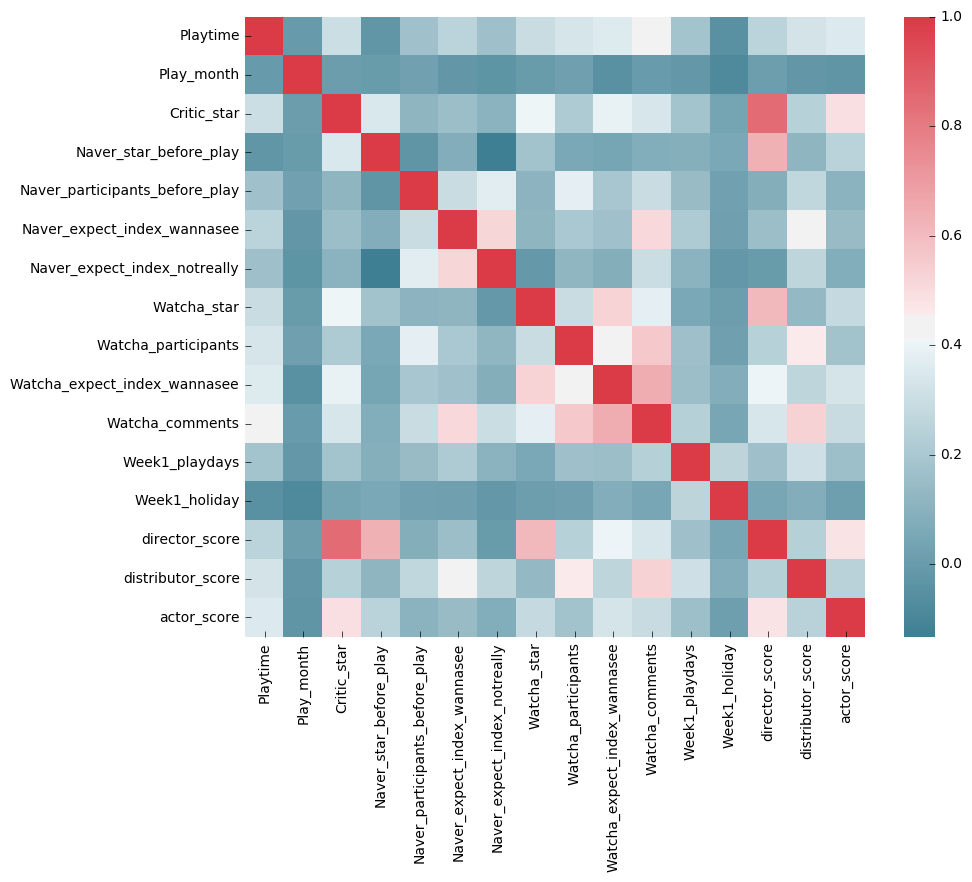

In [27]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = numeric_datas.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [28]:
corr

,Playtime,Play_month,Critic_star,Naver_star_before_play,Naver_participants_before_play,Naver_expect_index_wannasee,Naver_expect_index_notreally,Watcha_star,Watcha_participants,Watcha_expect_index_wannasee,Watcha_comments,Week1_playdays,Week1_holiday,director_score,distributor_score,actor_score
Playtime,1.000000,-0.006766,0.301489,-0.026415,0.169913,0.252923,0.163663,0.294967,0.334177,0.358764,0.414492,0.183637,-0.047955,0.254733,0.325018,0.357121
Play_month,-0.006766,1.000000,0.007777,0.002262,0.022913,-0.022373,-0.032506,-0.000309,0.021209,-0.046934,-0.002090,-0.017127,-0.080609,0.012286,-0.018295,-0.027083
Critic_star,0.301489,0.007777,1.000000,0.349077,0.117985,0.155101,0.104397,0.408069,0.213747,0.389554,0.337085,0.184367,0.039261,0.845864,0.238898,0.494123
Naver_star_before_play,-0.026415,0.002262,0.349077,1.000000,-0.029393,0.080486,-0.133226,0.180216,0.054827,0.039995,0.076289,0.091071,0.055539,0.635858,0.116730,0.249981
Naver_participants_before_play,0.169913,0.022913,0.117985,-0.029393,1.000000,0.294017,0.367188,0.106420,0.381183,0.192878,0.292428,0.145532,0.025307,0.084120,0.269932,0.102908
Naver_expect_index_wannasee,0.252923,-0.022373,0.155101,0.080486,0.294017,1.000000,0.519406,0.117096,0.202884,0.169780,0.510285,0.214808,0.020655,0.155895,0.417988,0.141722
Naver_expect_index_notreally,0.163663,-0.032506,0.104397,-0.133226,0.367188,0.519406,1.000000,-0.009447,0.120148,0.085250,0.296189,0.102949,-0.017439,0.001001,0.264318,0.078150
Watcha_star,0.294967,-0.000309,0.408069,0.180216,0.106420,0.117096,-0.009447,1.000000,0.293250,0.527058,0.382240,0.052771,0.011349,0.608419,0.136285,0.279731
Watcha_participants,0.334177,0.021209,0.213747,0.054827,0.381183,0.202884,0.120148,0.293250,1.000000,0.421131,0.561480,0.164347,0.017583,0.239575,0.456081,0.177157
Watcha_expect_index_wannasee,0.358764,-0.046934,0.389554,0.039995,0.192878,0.169780,0.085250,0.527058,0.421131,1.000000,0.647220,0.154692,0.082957,0.404836,0.262871,0.329838


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f4fefa0b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0f45e4e0f0>]], dtype=object)

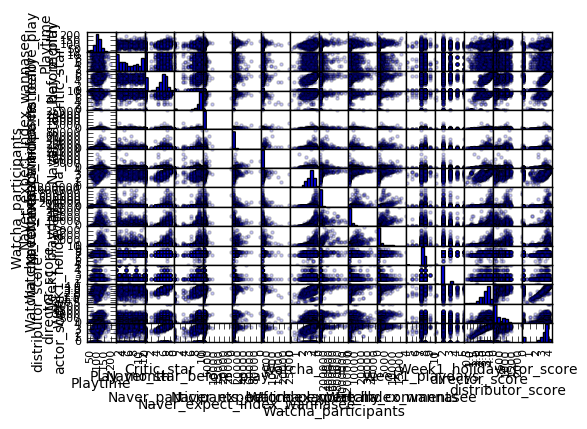

In [29]:
pd.tools.plotting.scatter_matrix(numeric_datas, alpha = 0.2)

## numeric data 정리 

상관분석 결과로부터 0.5이상의 어느정도 상관관계가 있다고 나타난 변수는 
Naver_expect_index_wannasee, Watcha_participants, Watcha_comments, distributor_score로
4개정도로 나타났다. 

In [30]:
classification_data.append('Week1_audience')
category_data = total[classification_data]

## 분산분석을 통해 검정하기 전에 등분산을 각 변수에 대해 등분산성을 검정한다. 
import scipy.stats as ss
category_data.Weekdays = pd.Categorical(category_data.Weekdays)
category_data.Rep_Nationality = pd.Categorical(category_data.Rep_Nationality)
category_data.Grade = pd.Categorical(category_data.Grade)
category_data.Rep_genre = pd.Categorical(category_data.Rep_genre)

category_data['Weekdays_i'] = category_data.Weekdays.cat.codes
category_data['Rep_Nationality_i'] = category_data.Rep_Nationality.cat.codes
category_data['Grade_i'] = category_data.Grade.cat.codes
category_data['Rep_genre_i'] = category_data.Rep_genre.cat.codes



/home/junhee/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/junhee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/junhee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [31]:
#1. Weekdays
#tt=category_data.Week1_audience.tolist()
#print(category_data.head())
weekdays = category_data['Weekdays_i'].tolist()
#print(weekdays)
audience = category_data['Week1_audience'].tolist()
ss.bartlett(audience,weekdays)
#ss.bartlett(category_data['Week1_audience'].tolist(), category_data['Weekdays_i'].tolist())

BartlettResult(statistic=29766.358379312973, pvalue=0.0)

In [32]:
#2. Rep_Nationality
rep_nation = category_data['Rep_Nationality_i'].tolist()
ss.bartlett(audience, rep_nation)

BartlettResult(statistic=28305.157891718947, pvalue=0.0)

In [33]:
#3. Grade
grade = category_data['Grade_i'].tolist()
ss.bartlett(audience,grade)

BartlettResult(statistic=29070.693250354558, pvalue=0.0)

In [34]:
#4. Rep_genre
genre = category_data['Rep_genre_i'].tolist()
ss.bartlett(audience, genre)

BartlettResult(statistic=25539.693512202935, pvalue=0.0)

In [35]:
#Anova - Kruskal-Wallis H-test 

def supply_dict(col, df):
    w_list = [i for i in set(df[col])]
    wdict = defaultdict(list)
    
    for ww in w_list:
        wdict[ww].append([df['Week1_audience'][i] for i, w in enumerate(df[col]) if w == ww])
    
    return wdict

In [37]:
from scipy.stats import mstats 

weekdict = supply_dict('Weekdays', category_data)

print("Kruskal Wallis H-test test (Weekdays):")

H, pval = mstats.kruskalwallis(weekdict['일요일'][0],
          weekdict['금요일'][0],
          weekdict['월요일'][0],
          weekdict['화요일'][0],
          weekdict['수요일'][0],
          weekdict['토요일'][0],
          weekdict['목요일'][0])

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test (Weekdays):
H-statistic: 243.025568983
P-Value: 1.26773936013e-49
Reject NULL hypothesis - Significant differences exist between groups.


In [39]:
#2. Rep_Nationality
nationdict = supply_dict('Rep_Nationality', category_data)
params = [nationdict[i][0] for i in nationdict.keys()]
H, pval = mstats.kruskalwallis(*params)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

H-statistic: 156.148224843
P-Value: 9.79215144589e-33
Reject NULL hypothesis - Significant differences exist between groups.


In [40]:
#3. Grade
grdedict = supply_dict('Grade', category_data)
params = [grdedict[i][0] for i in grdedict.keys()]
H, pval = mstats.kruskalwallis(*params)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

H-statistic: 31.0542886584
P-Value: 8.27965794324e-07
Reject NULL hypothesis - Significant differences exist between groups.


In [41]:
#4. Rep_genre
genredict = supply_dict('Rep_genre', category_data)
params = [genredict[i][0] for i in genredict.keys()]
H, pval = mstats.kruskalwallis(*params)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups")


H-statistic: 226.397005438
P-Value: 3.47078101976e-39
Reject NULL hypothesis - Significant differences exist between groups.


## anova 결과 

검정 결과 4개의 category 변수 그룹간 차이가 유의함을 알 수 있다. 

In [42]:
total.to_csv('total.csv', encoding = 'cp949')

In [68]:
testl = test.Movie.tolist()
new_test = total[total['Movie'].isin(testl)]
validationl = validation.Movie.tolist()
new_validation = total[total.Movie.isin(validationl)]
trainl = df.Movie.tolist()
new_train = total[total.Movie.isin(trainl)]

new_test.to_csv('new_test.csv', encoding = 'cp949')
new_train.to_csv('new_train.csv', encoding = 'cp949')
new_validation.to_csv('new_validation.csv', encoding = 'cp949')